In [1]:
x=1

In [2]:
import scanpy as sc
import pandas as pd
import decoupler as dc
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [3]:
adata = sc.read('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/snakemake/pbmc/3fold/data/pp/rna_hvg_squished.h5ad')
adata

AnnData object with n_obs × n_vars = 588260 × 2000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'condition', 'sample', 'batch', 'split0', 'split1', 'split2'
    var: 'feature_types', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'counts'

In [4]:
adata.X.data

array([ 6., 26.,  2., ...,  4.,  2., 10.], dtype=float32)

In [5]:
DONOR = 'sample'
CONDITION = 'condition'

# Create pseudobulks

In [6]:
# Get pseudo-bulk profile
adata_ = dc.get_pseudobulk(adata, sample_col=DONOR, groups_col=None, min_prop=-1, min_smpls=0, min_cells=0, min_counts=0)
adata_

View of AnnData object with n_obs × n_vars = 114 × 2000
    obs: 'sample_id', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'condition', 'sample', 'batch', 'split0', 'split1', 'split2', 'psbulk_n_cells', 'psbulk_counts'
    var: 'feature_types', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    layers: 'psbulk_props'

In [7]:
adata_.obs[CONDITION] = adata_.obs[CONDITION].astype('category')
rename_dict = {name: number for number, name in enumerate(sorted(list(adata_.obs[CONDITION].cat.categories)))}
rename_dict

{'Healthy': 0, 'Mild': 1, 'Severe': 2}

# Multiclass regression

In [8]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax
onehot_encoder = OneHotEncoder(sparse=False)
from scipy.special import logsumexp

In [9]:
def loss(X, Y, W):
    """
    Y: onehot encoded
    """
    Z = - X @ W
    N = X.shape[0]
    loss = 1/N * (np.trace(X @ W @ Y.T) + np.sum(logsumexp(Z, axis=1)))
    return loss

def gradient(X, Y, W, mu):
    """
    Y: onehot encoded 
    """
    Z = - X @ W
    P = softmax(Z, axis=1)
    N = X.shape[0]
    gd = 1/N * (X.T @ (Y - P)) + 2 * mu * W
    return gd

def gradient_descent(X, Y, max_iter=2000, eta=0.1, mu=0.01):
    """
    Very basic gradient descent algorithm with fixed eta and mu
    """
    Y_onehot = onehot_encoder.fit_transform(Y.reshape(-1,1))
    W = np.zeros((X.shape[1], Y_onehot.shape[1]))
    step = 0
    step_lst = [] 
    loss_lst = []
    W_lst = []
 
    while step < max_iter:
        step += 1
        W -= eta * gradient(X, Y_onehot, W, mu)
        step_lst.append(step)
        W_lst.append(W)
        loss_lst.append(loss(X, Y_onehot, W))

    df = pd.DataFrame({
        'step': step_lst, 
        'loss': loss_lst
    })
    return df, W

class Multiclass:
    def fit(self, X, Y):
        self.loss_steps, self.W = gradient_descent(X, Y)

    def loss_plot(self):
        return self.loss_steps.plot(
            x='step', 
            y='loss',
            xlabel='step',
            ylabel='loss'
        )

    def predict(self, H):
        Z = - H @ self.W
        P = softmax(Z, axis=1)
        return np.argmax(P, axis=1)

In [10]:
adata_.obs[CONDITION] = adata_.obs[CONDITION].astype('category')

Processing split = 0...
Train shapes:
x.shape = (65, 2000)
y.shape = (65,)
Val shapes:
x_val.shape = (49, 2000)
y_val.shape = (49,)
Train accuracy = 0.5538461538461539.
class report
              precision    recall  f1-score    support
0              0.333333  0.333333  0.333333  12.000000
1              0.500000  0.750000  0.600000  24.000000
2              1.000000  0.076923  0.142857  13.000000
accuracy       0.469388  0.469388  0.469388   0.469388
macro avg      0.611111  0.386752  0.358730  49.000000
weighted avg   0.591837  0.469388  0.413411  49.000000
Val accuracy = 0.46938775510204084.
Processing split = 1...
Train shapes:
x.shape = (60, 2000)
y.shape = (60,)
Val shapes:
x_val.shape = (54, 2000)
y_val.shape = (54,)
Train accuracy = 0.65.
class report
              precision    recall  f1-score    support
0              0.857143  0.500000  0.631579  12.000000
1              0.875000  0.250000  0.388889  28.000000
2              0.333333  0.928571  0.490566  14.000000
accuracy 

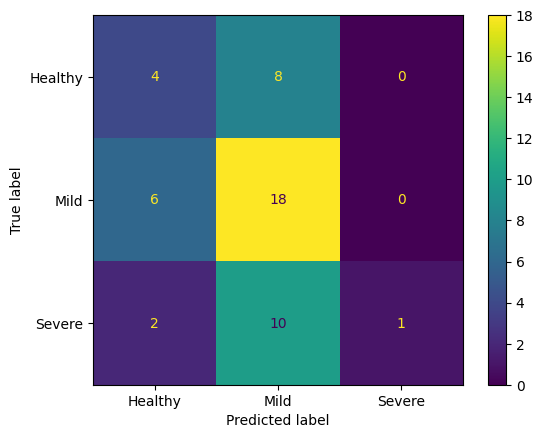

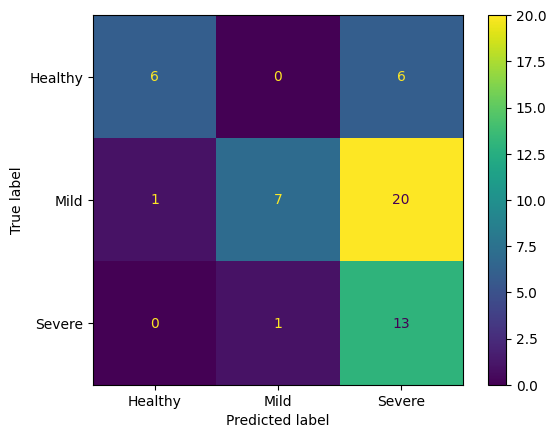

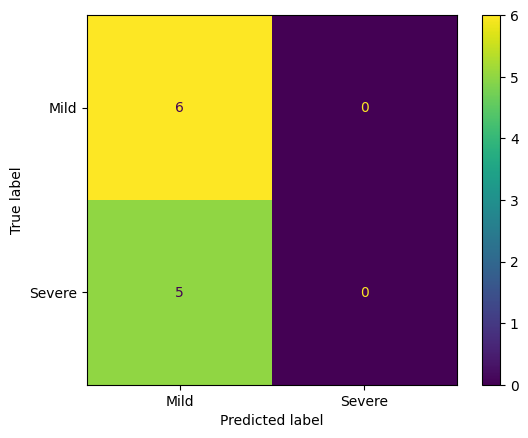

In [11]:
val_accuracies = []
val_avg = []

val_obs_names = {}
val_true = {}
val_predicted = {}

for i in range(3):
    print(f'Processing split = {i}...')
    df = adata.obs[[f'split{i}', DONOR]].drop_duplicates()
    train = list(df[df[f'split{i}'] == 'train'][DONOR])
    val = list(df[df[f'split{i}'] == 'val'][DONOR])
    # train data
    x = pd.DataFrame(adata_[adata_.obs_names.isin(train)].X).to_numpy()
    num_of_classes = len(adata_.obs[CONDITION].cat.categories)
    y = adata_[adata_.obs_names.isin(train)].obs[CONDITION].cat.rename_categories(rename_dict)
    y = y.to_numpy()
    print("Train shapes:")
    print(f"x.shape = {x.shape}")
    print(f"y.shape = {y.shape}")
    # val data
    x_val = pd.DataFrame(adata_[adata_.obs_names.isin(val)].X).to_numpy()
    y_val = adata_[adata_.obs_names.isin(val)].obs[CONDITION].cat.rename_categories(rename_dict)
    y_val = y_val.to_numpy()
    print("Val shapes:")
    print(f"x_val.shape = {x_val.shape}")
    print(f"y_val.shape = {y_val.shape}")
    # fit
    X = x
    Y = y
    model = Multiclass()
    model.fit(X, Y)
    print(f'Train accuracy = {np.sum(model.predict(X) == Y)/len(Y)}.')
    y_pred = model.predict(x_val)
    val_obs_names[i] = adata_[adata_.obs_names.isin(val)].obs_names
    val_true[i] = y_val
    val_predicted[i] = y_pred
    df = classification_report(y_val, y_pred, output_dict=True)
    df = pd.DataFrame(df).T
        
    print('class report')
    print(df)

    print(f'Val accuracy = {df["f1-score"]["accuracy"]}.')

    cm = sklearn.metrics.confusion_matrix(y_val, y_pred)
    if cm.shape[0] == 3:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Mild', 'Severe'])
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Mild', 'Severe'])
    
    disp.plot()
    
    print('===========================')
    
    val_accuracies.append(df["f1-score"]["accuracy"])
    val_avg.append(df["f1-score"]["weighted avg"])

print(f"Mean validation accuracy across 5 CV splits for a multiclass regression model = {np.mean(np.array(val_accuracies))}.")
print(f"Mean validation weighted avg across 5 CV splits for a multiclass regression model = {np.mean(np.array(val_avg))}.")

In [12]:
print(val_obs_names)

{0: Index(['BGCV01_CV0025', 'BGCV01_CV0144', 'BGCV01_CV0902', 'BGCV01_CV0904',
       'BGCV02_CV0052', 'BGCV02_CV0902', 'BGCV03_CV0074', 'BGCV03_CV0084',
       'BGCV03_CV0176', 'BGCV03_CV0200', 'BGCV04_CV0100', 'BGCV04_CV0911',
       'BGCV05_CV0120', 'BGCV05_CV0128', 'BGCV05_CV0284', 'BGCV05_CV0929',
       'BGCV06_CV0037', 'BGCV06_CV0178', 'BGCV06_CV0201', 'BGCV06_CV0234',
       'BGCV07_CV0094', 'BGCV07_CV0104', 'BGCV07_CV0134', 'BGCV07_CV0137',
       'BGCV08_CV0073', 'BGCV08_CV0201', 'BGCV08_CV0915', 'BGCV09_CV0062',
       'BGCV09_CV0279', 'BGCV09_CV0917', 'BGCV10_CV0160', 'BGCV10_CV0198',
       'BGCV10_CV0939', 'BGCV11_CV0050', 'BGCV11_CV0180', 'BGCV11_CV0257',
       'BGCV12_CV0062', 'BGCV12_CV0178', 'BGCV12_CV0926', 'BGCV13_CV0073',
       'BGCV13_CV0326', 'BGCV13_CV0934', 'BGCV14_CV0050', 'BGCV14_CV0137',
       'BGCV14_CV0284', 'BGCV14_CV0940', 'BGCV15_CV0176', 'BGCV15_CV0257',
       'BGCV15_CV0944'],
      dtype='object'), 1: Index(['MH8919176', 'MH8919177', 'MH8919178',

In [13]:
print(val_true)

{0: array([1, 2, 0, 0, 1, 0, 1, 1, 2, 2, 1, 0, 1, 1, 2, 0, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1,
       2, 0, 2, 1, 0]), 1: array([0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 2, 2, 1,
       1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 2, 1, 2, 2, 2, 1, 0, 0]), 2: array([2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1])}


In [14]:
print(val_predicted)

{0: array([0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1]), 1: array([0, 0, 0, 0, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 0, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 0, 2]), 2: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}


# NN

In [15]:
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from random import sample
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [17]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_out(x)
        
        return x

In [18]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [19]:
adata_.obs[CONDITION] = adata_.obs[CONDITION].astype('category')

In [20]:
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 0.00005
NUM_FEATURES = adata_.shape[1]
NUM_CLASSES = len(adata_.obs[CONDITION].cat.categories)
TRAIN_FRACTION = 0.8

Processing split = 0...
Train shapes:
x.shape = (65, 2000)
y.shape = (65,)
Val shapes:
x_val.shape = (49, 2000)
y_val.shape = (49,)
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: | Train Loss: 0.20657 | Val Loss: 1.38153 | Train Acc: 100.000| Val Acc: 30.769
class report
              precision    recall  f1-score    support
0              0.255319  1.000000  0.406780  12.000000
1              0.000000  0.000000  0.000000  24.000000
2              0.500000  0.076923  0.133333  13.000000
accuracy       0.265306  0.265306  0.265306   0.265306
macro avg      0.251773  0.358974  0.180038  49.000000
weighted avg   0.195180  0.265306  0.134994  49.000000
Accuracy on the test set = 0.2653061224489796.
Processing split = 1...
Train shapes:
x.shape = (60, 2000)
y.shape = (60,)
Val shapes:
x_val.shape = (54, 2000)
y_val.shape = (54,)
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: | Train Loss: 0.24943 | Val Loss: 0.99950 | Train Acc: 100.000| Val Acc: 66.667
class report
              precision    recall  f1-score    support
0              0.411765  0.583333  0.482759  12.000000
1              0.875000  0.250000  0.388889  28.000000
2              0.482759  1.000000  0.651163  14.000000
accuracy       0.518519  0.518519  0.518519   0.518519
macro avg      0.589841  0.611111  0.507603  54.000000
weighted avg   0.670367  0.518519  0.477746  54.000000
Accuracy on the test set = 0.5185185185185185.
Processing split = 2...
Train shapes:
x.shape = (103, 2000)
y.shape = (103,)
Val shapes:
x_val.shape = (11, 2000)
y_val.shape = (11,)
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: | Train Loss: 0.22520 | Val Loss: 0.71869 | Train Acc: 99.000| Val Acc: 80.000
class report
              precision    recall  f1-score    support
0              0.000000  0.000000  0.000000   0.000000
1              0.400000  0.333333  0.363636   6.000000
2              0.333333  0.200000  0.250000   5.000000
accuracy       0.272727  0.272727  0.272727   0.272727
macro avg      0.244444  0.177778  0.204545  11.000000
weighted avg   0.369697  0.272727  0.311983  11.000000
Accuracy on the test set = 0.2727272727272727.
Mean validation accuracy across 5 CV splits for a NN model = 0.35218397123159023.
Mean validation weighted avg across 5 CV splits for a NN model = 0.3082409654499207.


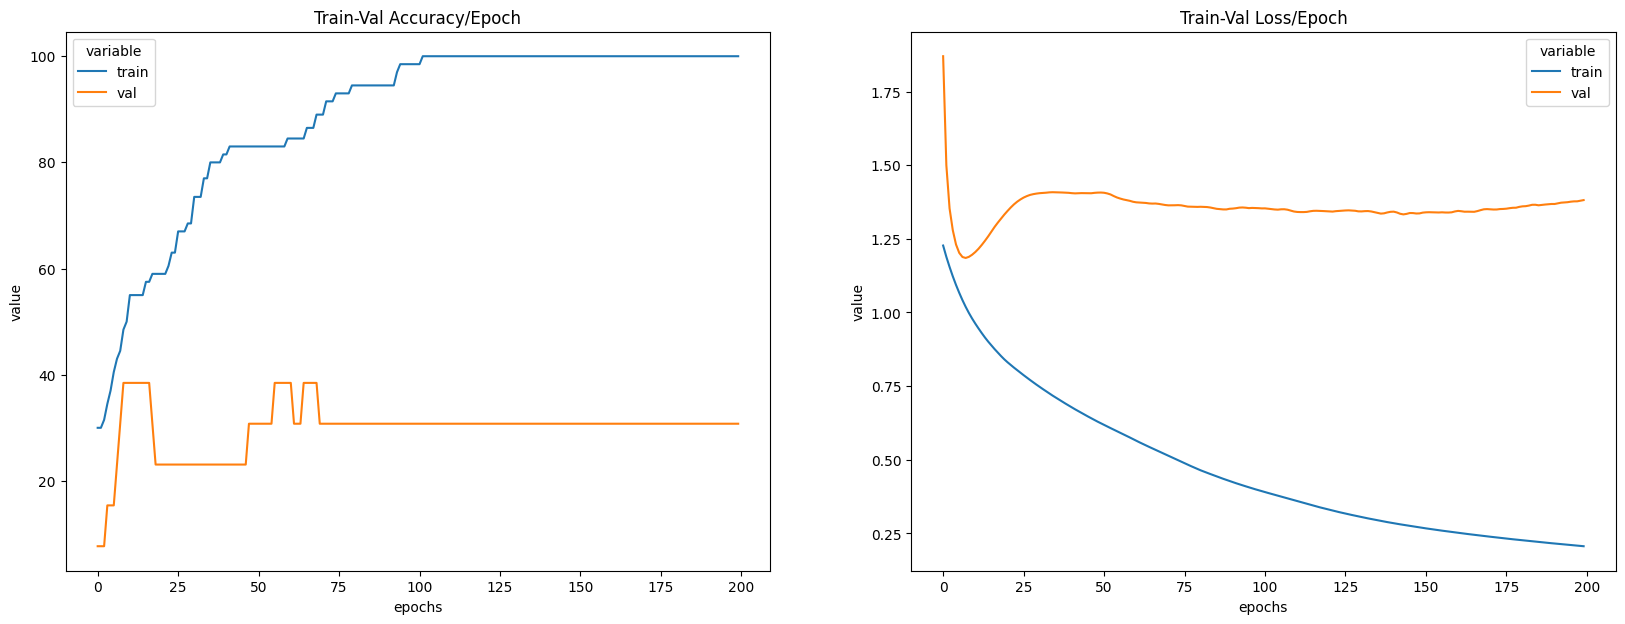

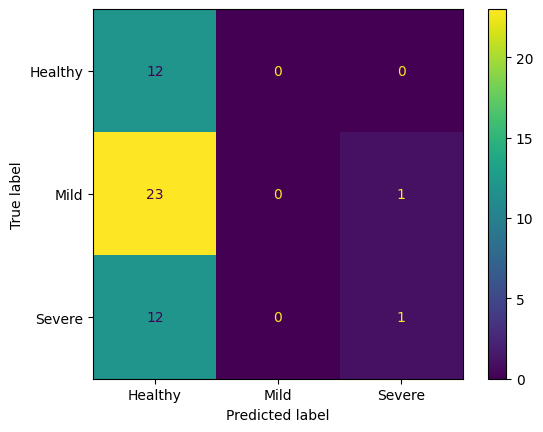

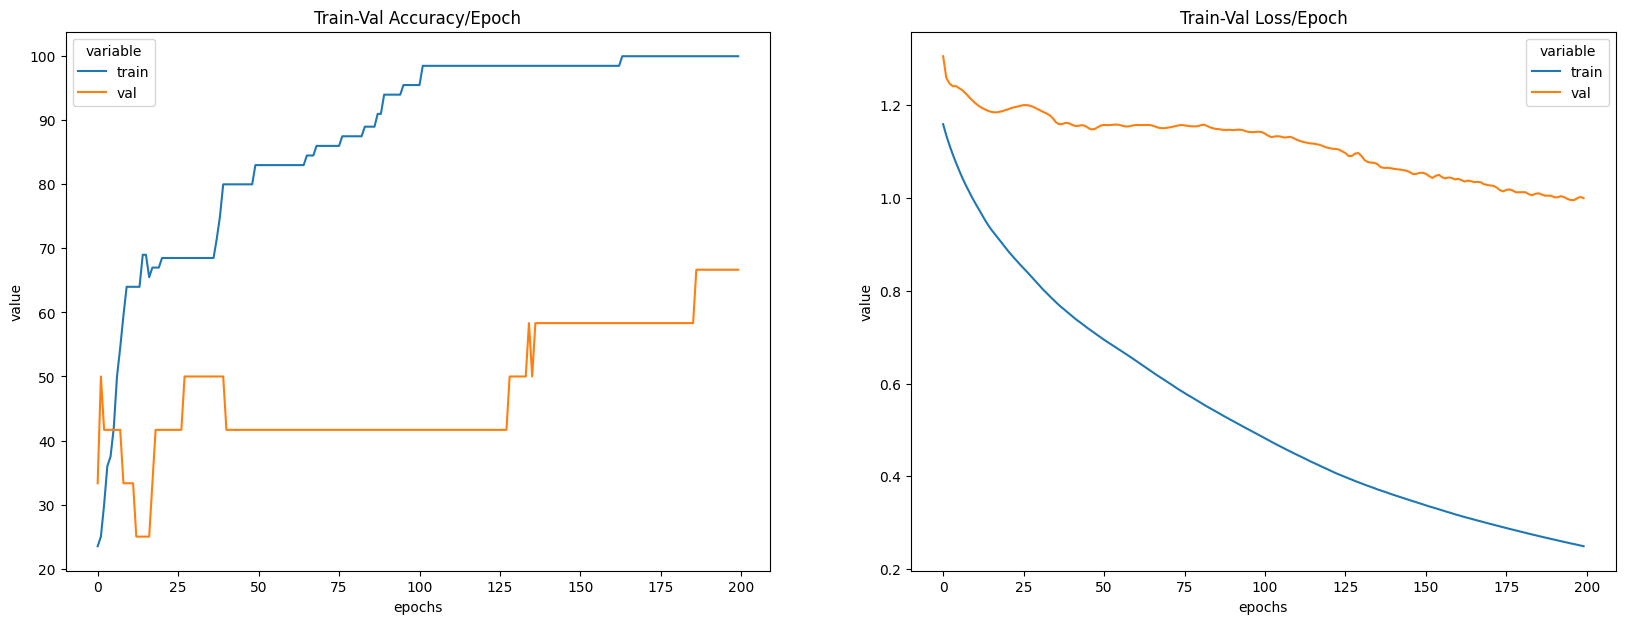

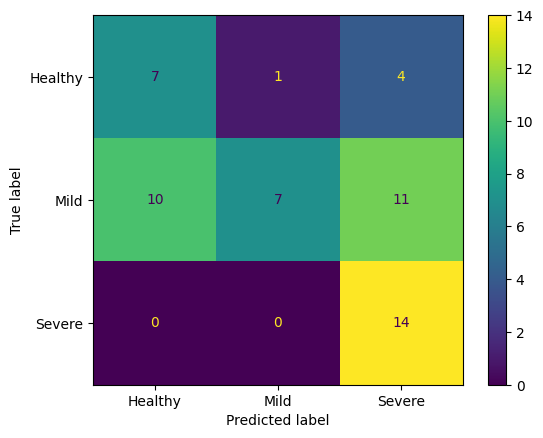

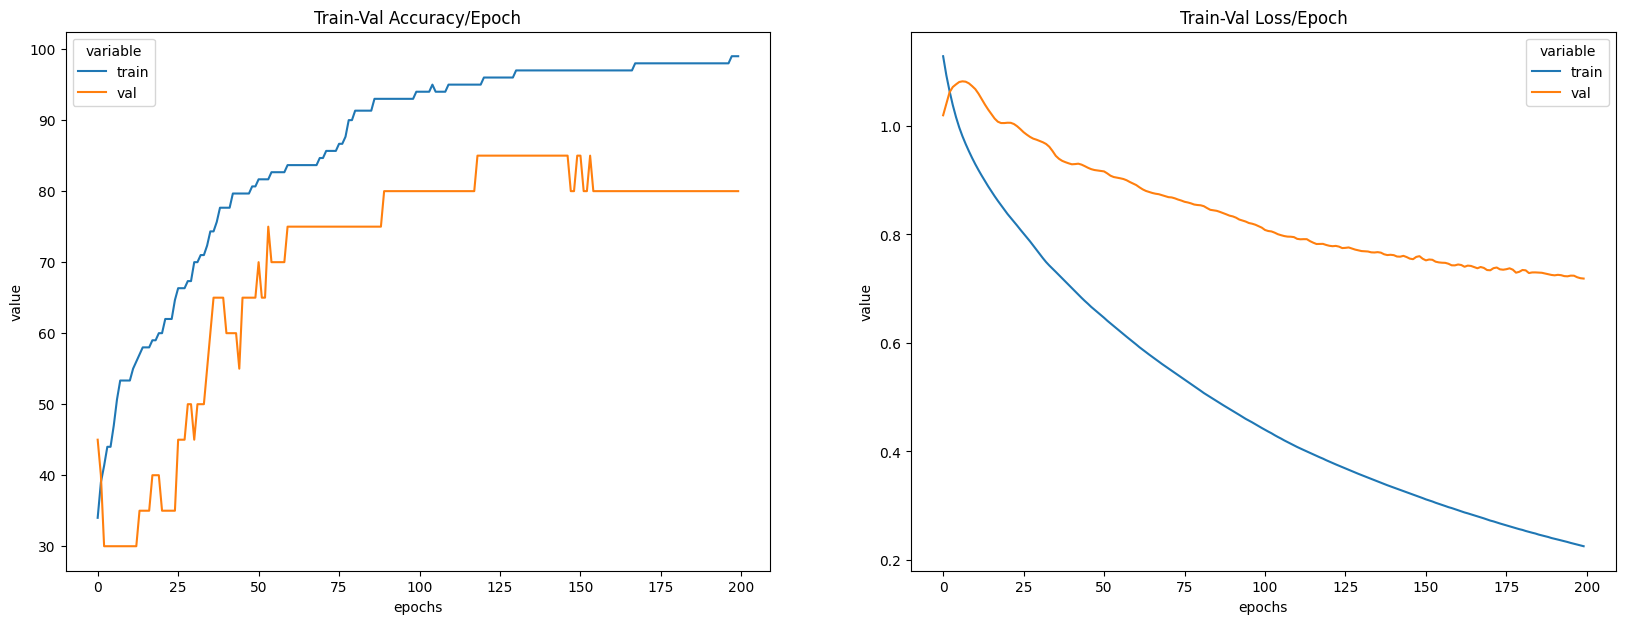

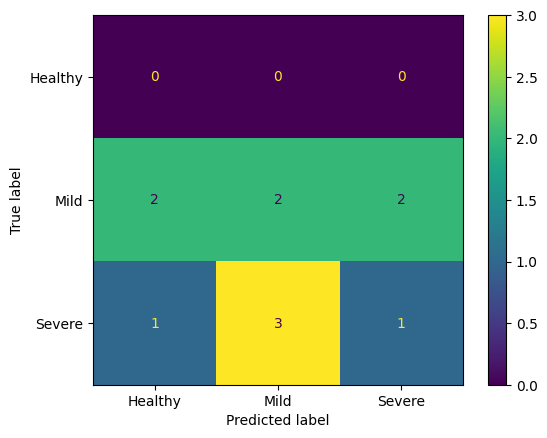

In [21]:
val_accuracies = []
val_avg = []

val_obs_names = {}
val_true = {}
val_predicted = {}

for i in range(3):
    print(f'Processing split = {i}...')
    df = adata.obs[[f'split{i}', DONOR]].drop_duplicates()
    train = list(df[df[f'split{i}'] == 'train'][DONOR])
    val = list(df[df[f'split{i}'] == 'val'][DONOR])
    # train data
    x = pd.DataFrame(adata_[adata_.obs_names.isin(train)].X).to_numpy()
    num_of_classes = len(adata_.obs[CONDITION].cat.categories)
    y = adata_[adata_.obs_names.isin(train)].obs[CONDITION].cat.rename_categories(rename_dict)
    y = y.to_numpy()
    print("Train shapes:")
    print(f"x.shape = {x.shape}")
    print(f"y.shape = {y.shape}")
    # val data, later this is called test data because the val data is subset of train
    x_val = pd.DataFrame(adata_[adata_.obs_names.isin(val)].X).to_numpy()
    y_val = adata_[adata_.obs_names.isin(val)].obs[CONDITION].cat.rename_categories(rename_dict)
    y_val = y_val.to_numpy()
    print("Val shapes:")
    print(f"x_val.shape = {x_val.shape}")
    print(f"y_val.shape = {y_val.shape}")
    # fit
    X = x
    Y = y
    n_of_train_samples = int(math.ceil(len(y) * TRAIN_FRACTION))
    train_samples = sample(range(len(y)), n_of_train_samples)
    val_samples = [i for i in range(len(y)) if i not in train_samples]
    X_test = x_val
    y_test = y_val
    X_train = x[train_samples]
    y_train = y[train_samples]
    X_val = x[val_samples]
    y_val = y[val_samples]
    
    # create datasets
    train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
    
    # create loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)
    
    # init model
    model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
    # define loss
    criterion = nn.CrossEntropyLoss()
    # define optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # loss recoder
    accuracy_stats = {
        'train': [],
        "val": []
    }
    loss_stats = {
        'train': [],
        "val": []
    }
    
    # train
    print("Begin training.")
    for e in tqdm(range(1, EPOCHS+1)):

        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch, y_train_batch
            optimizer.zero_grad()

            y_train_pred = model(X_train_batch)

            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()


        # VALIDATION    
        with torch.no_grad():

            val_epoch_loss = 0
            val_epoch_acc = 0

            model.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch, y_val_batch

                y_val_pred = model(X_val_batch)

                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)

                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()

        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    
    # losses
    # Create dataframes
    train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    # Plot the dataframes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
    sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')
    
    # predict
    y_pred_list = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in test_loader:
            X_batch = X_batch
            y_test_pred = model(X_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    val_obs_names[i] = adata_[adata_.obs_names.isin(val)].obs_names
    val_true[i] = y_test
    val_predicted[i] = y_pred_list
    
    df = classification_report(y_test, y_pred_list, output_dict=True)
    df = pd.DataFrame(df).T
    print('class report')
    print(df)
    
    val_accuracies.append(df["f1-score"]["accuracy"])
    val_avg.append(df["f1-score"]["weighted avg"])
    
    print(f'Accuracy on the test set = {df["f1-score"]["accuracy"]}.')

    y_pred = y_pred_list
    y_val = y_test
    
    cm = sklearn.metrics.confusion_matrix(y_val, y_pred)
    if cm.shape[0] == 3:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Mild', 'Severe'])
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Mild', 'Severe'])
    disp.plot()
    
    print('===========================')
    
print(f"Mean validation accuracy across 5 CV splits for a NN model = {np.mean(np.array(val_accuracies))}.")
print(f"Mean validation weighted avg across 5 CV splits for a NN model = {np.mean(np.array(val_avg))}.")


In [22]:
print(val_obs_names)

{0: Index(['BGCV01_CV0025', 'BGCV01_CV0144', 'BGCV01_CV0902', 'BGCV01_CV0904',
       'BGCV02_CV0052', 'BGCV02_CV0902', 'BGCV03_CV0074', 'BGCV03_CV0084',
       'BGCV03_CV0176', 'BGCV03_CV0200', 'BGCV04_CV0100', 'BGCV04_CV0911',
       'BGCV05_CV0120', 'BGCV05_CV0128', 'BGCV05_CV0284', 'BGCV05_CV0929',
       'BGCV06_CV0037', 'BGCV06_CV0178', 'BGCV06_CV0201', 'BGCV06_CV0234',
       'BGCV07_CV0094', 'BGCV07_CV0104', 'BGCV07_CV0134', 'BGCV07_CV0137',
       'BGCV08_CV0073', 'BGCV08_CV0201', 'BGCV08_CV0915', 'BGCV09_CV0062',
       'BGCV09_CV0279', 'BGCV09_CV0917', 'BGCV10_CV0160', 'BGCV10_CV0198',
       'BGCV10_CV0939', 'BGCV11_CV0050', 'BGCV11_CV0180', 'BGCV11_CV0257',
       'BGCV12_CV0062', 'BGCV12_CV0178', 'BGCV12_CV0926', 'BGCV13_CV0073',
       'BGCV13_CV0326', 'BGCV13_CV0934', 'BGCV14_CV0050', 'BGCV14_CV0137',
       'BGCV14_CV0284', 'BGCV14_CV0940', 'BGCV15_CV0176', 'BGCV15_CV0257',
       'BGCV15_CV0944'],
      dtype='object'), 1: Index(['MH8919176', 'MH8919177', 'MH8919178',

In [23]:
print(val_true)

{0: array([1, 2, 0, 0, 1, 0, 1, 1, 2, 2, 1, 0, 1, 1, 2, 0, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1,
       2, 0, 2, 1, 0]), 1: array([0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 2, 2, 1,
       1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 2, 1, 2, 2, 2, 1, 0, 0]), 2: array([2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1])}


In [24]:
print(val_predicted)

{0: [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1: [0, 0, 0, 0, 1, 2, 0, 2, 1, 2, 2, 2, 0, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0], 2: [2, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2]}


# Random forest

Adjusted from https://www.datacamp.com/tutorial/random-forests-classifier-python.

In [25]:
from sklearn.ensemble import RandomForestClassifier

Processing split = 0...
Train shapes:
x.shape = (65, 2000)
y.shape = (65,)
Val shapes:
x_val.shape = (49, 2000)
y_val.shape = (49,)
Train accuracy = 0.9692307692307692.
class report
              precision    recall  f1-score    support
0              0.324324  1.000000  0.489796  12.000000
1              0.250000  0.041667  0.071429  24.000000
2              0.250000  0.153846  0.190476  13.000000
accuracy       0.306122  0.306122  0.306122   0.306122
macro avg      0.274775  0.398504  0.250567  49.000000
weighted avg   0.268202  0.306122  0.205470  49.000000
Val accuracy = 0.30612244897959184.
Processing split = 1...
Train shapes:
x.shape = (60, 2000)
y.shape = (60,)
Val shapes:
x_val.shape = (54, 2000)
y_val.shape = (54,)
Train accuracy = 0.95.
class report
              precision    recall  f1-score    support
0              0.750000  0.250000  0.375000  12.000000
1              0.615385  0.285714  0.390244  28.000000
2              0.297297  0.785714  0.431373  14.000000
accuracy 

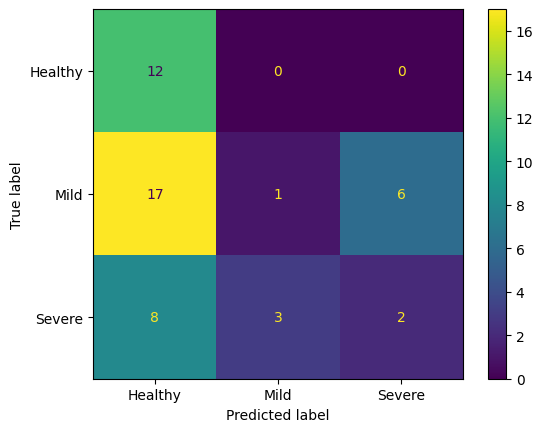

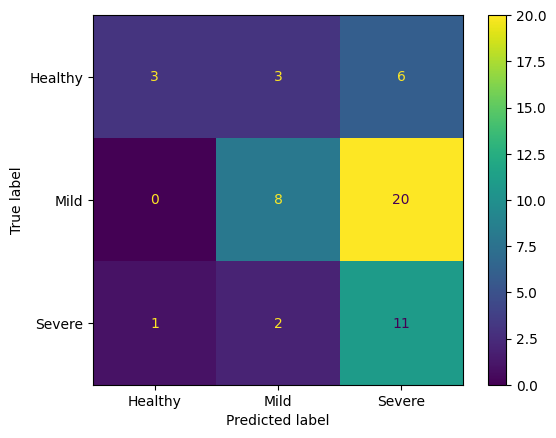

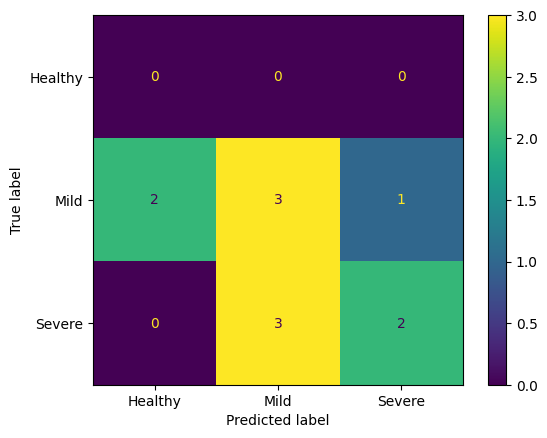

In [26]:
val_accuracies = []
val_avg = []

val_obs_names = {}
val_true = {}
val_predicted = {}

for i in range(3):
    print(f'Processing split = {i}...')
    df = adata.obs[[f'split{i}', DONOR]].drop_duplicates()
    train = list(df[df[f'split{i}'] == 'train'][DONOR])
    val = list(df[df[f'split{i}'] == 'val'][DONOR])
    # train data
    x = pd.DataFrame(adata_[adata_.obs_names.isin(train)].X).to_numpy()
    num_of_classes = len(adata_.obs[CONDITION].cat.categories)
    y = adata_[adata_.obs_names.isin(train)].obs[CONDITION].cat.rename_categories(rename_dict)
    y = y.to_numpy()
    print("Train shapes:")
    print(f"x.shape = {x.shape}")
    print(f"y.shape = {y.shape}")
    # val data
    x_val = pd.DataFrame(adata_[adata_.obs_names.isin(val)].X).to_numpy()
    y_val = adata_[adata_.obs_names.isin(val)].obs[CONDITION].cat.rename_categories(rename_dict)
    y_val = y_val.to_numpy()
    print("Val shapes:")
    print(f"x_val.shape = {x_val.shape}")
    print(f"y_val.shape = {y_val.shape}")
    # fit
    X = x
    Y = y
    clf = RandomForestClassifier(n_estimators=5)
    clf.fit(X, Y)
    print(f'Train accuracy = {np.sum(clf.predict(X) == Y)/len(Y)}.')
    y_pred = clf.predict(x_val)
    val_accuracy = np.sum(y_pred == y_val)/len(y_val)
    
    df = classification_report(y_val, y_pred, output_dict=True)
    df = pd.DataFrame(df).T
    print('class report')
    print(df)

    val_obs_names[i] = adata_[adata_.obs_names.isin(val)].obs_names
    val_true[i] = y_val
    val_predicted[i] = y_pred
    
    val_accuracies.append(df["f1-score"]["accuracy"])
    val_avg.append(df["f1-score"]["weighted avg"])
    
    val_accuracy = df["f1-score"]["accuracy"]
    
    print(f'Val accuracy = {val_accuracy}.')

    cm = sklearn.metrics.confusion_matrix(y_val, y_pred)
    if cm.shape[0] == 3:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Mild', 'Severe'])
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Mild', 'Severe'])
    disp.plot()
    
    print('===========================')


print(f"Mean validation accuracy across 5 CV splits for a random forest model = {np.mean(np.array(val_accuracies))}.")
print(f"Mean validation weighted avg across 5 CV splits for a random forest model = {np.mean(np.array(val_avg))}.")


In [27]:
print(val_obs_names)

{0: Index(['BGCV01_CV0025', 'BGCV01_CV0144', 'BGCV01_CV0902', 'BGCV01_CV0904',
       'BGCV02_CV0052', 'BGCV02_CV0902', 'BGCV03_CV0074', 'BGCV03_CV0084',
       'BGCV03_CV0176', 'BGCV03_CV0200', 'BGCV04_CV0100', 'BGCV04_CV0911',
       'BGCV05_CV0120', 'BGCV05_CV0128', 'BGCV05_CV0284', 'BGCV05_CV0929',
       'BGCV06_CV0037', 'BGCV06_CV0178', 'BGCV06_CV0201', 'BGCV06_CV0234',
       'BGCV07_CV0094', 'BGCV07_CV0104', 'BGCV07_CV0134', 'BGCV07_CV0137',
       'BGCV08_CV0073', 'BGCV08_CV0201', 'BGCV08_CV0915', 'BGCV09_CV0062',
       'BGCV09_CV0279', 'BGCV09_CV0917', 'BGCV10_CV0160', 'BGCV10_CV0198',
       'BGCV10_CV0939', 'BGCV11_CV0050', 'BGCV11_CV0180', 'BGCV11_CV0257',
       'BGCV12_CV0062', 'BGCV12_CV0178', 'BGCV12_CV0926', 'BGCV13_CV0073',
       'BGCV13_CV0326', 'BGCV13_CV0934', 'BGCV14_CV0050', 'BGCV14_CV0137',
       'BGCV14_CV0284', 'BGCV14_CV0940', 'BGCV15_CV0176', 'BGCV15_CV0257',
       'BGCV15_CV0944'],
      dtype='object'), 1: Index(['MH8919176', 'MH8919177', 'MH8919178',

In [28]:
print(val_true)

{0: array([1, 2, 0, 0, 1, 0, 1, 1, 2, 2, 1, 0, 1, 1, 2, 0, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1,
       2, 0, 2, 1, 0]), 1: array([0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 2, 2, 1,
       1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 2, 1, 2, 2, 2, 1, 0, 0]), 2: array([2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1])}


In [29]:
print(val_predicted)

{0: array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       1, 0, 0, 0, 0]), 1: array([2, 0, 2, 2, 0, 0, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 0, 1,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 1, 2, 2, 2, 1, 1, 2]), 2: array([1, 1, 1, 1, 1, 2, 1, 2, 0, 2, 0])}
